# Frequency Response

This notebook shows how to do a transient simulation at a given operation point.

In [1]:
import ams

In [2]:
%matplotlib inline

In [3]:
ams.config_logger(stream_level=30)

## Scheduling with AMS

In [4]:
sp = ams.load('./ieee39_econ.xlsx',
              setup=True,
              no_output=True,
              default_config=True)

In [5]:
sp.DCOPF.run(solver='CLARABEL')

Building system matrices
Parsing OModel for <DCOPF>
Evaluating OModel for <DCOPF>
Finalizing OModel for <DCOPF>
<DCOPF> solved as optimal in 0.0276 seconds, converged in 9 iterations with CLARABEL.


True

In [6]:
sp.DCOPF.dc2ac()

Parsing OModel for <ACOPF>
Evaluating OModel for <ACOPF>
Finalizing OModel for <ACOPF>
<DCOPF> converted to AC.


True

## Transient Simulation with ANDES

In [7]:
sa = sp.to_andes(setup=True,
                 addfile='./ieee39_dyn.xlsx',
                 no_output=True,
                 default_config=True,
                 verify=False)

Following PFlow models in addfile will be overwritten: <Bus>, <PQ>, <PV>, <Slack>, <Shunt>, <Line>, <Area>
AMS system 0x30e4a8530 is linked to the ANDES system 0x30fe3d460.


Send the schduling results to the ANDES case

In [8]:
sp.dyn.send(routine='DCOPF')

Send <vBus> to Bus.v0
Send <ug> to StaticGen.u
Send <pg> to StaticGen.p0


True

In [9]:
sa.PFlow.run()

True

In [10]:
_ = sa.TDS.init()

GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_1  | 0.014  | 0.001
 GENROU_3  | 0.018  | 0.003
 GENROU_4  | 0.013  | 0.001
 GENROU_5  | 0.014  | 0.001
 GENROU_7  | 0.015  | 0.002
 GENROU_8  | 0.015  | 0.006
 GENROU_9  | 0.009  | 0.001
 GENROU_10 | 0.013  | 0.000




In [11]:
syg_tripped = sa.Toggler.dev.v[0]
p_gap = sa.GENROU.Pe.v[sa.GENROU.idx2uid(syg_tripped)]

In [12]:
sa.TDS.config.tf = 50
sa.TDS.config.criteria = 0
sa.TDS.config.no_tqdm = True
sa.TDS.run()

<Toggle Toggler_1>: GENROU.GENROU_3 status changed to 0 at t=1.0 sec.


True

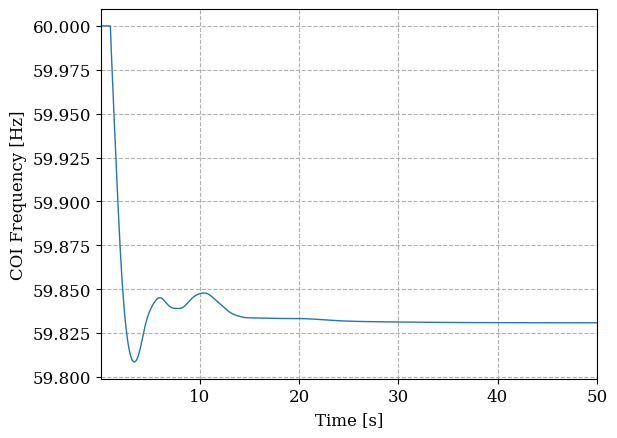

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Time [s]', ylabel='COI Frequency [Hz]'>)

In [13]:
sa.TDS.plt.plot(sa.COI.omega,
                ytimes=sa.config.freq,
                latex=False,
                grid=True,
                legend=False,
                ylabel='COI Frequency [Hz]')

## Post Contingency Calculation

In [14]:
print(f'Generator being tripped: {syg_tripped}')
print(f'Tripped power: {sa.config.mva * p_gap:.2f} MW')

B = sa.ACEc.bias.v[0]
f_dev =  1 - sa.COI.omega.v[0]
p_est = B * 10 * sa.config.freq * f_dev
print(f'Estimated power gap: {p_est:.2f} MW')

Generator being tripped: GENROU_3
Tripped power: 607.93 MW
Estimated power gap: 592.02 MW


## Re-solve DCOPF After Contingency

First, let's receive the transient simulation results from ANDES.

Here we set the ``no_update=True`` to skip the model updating step as we need to update the load later.

In [15]:
sp.dyn.receive(adsys=sa, routine='DCOPF', no_update=True)

True

Considering the primary frequency response is proportional control and cannot eliminate the frequency deviation,
we apply a pseudo propotional load shedding to mimic the gap.

For demo purpose, we assume the allowed post-contingency freuqnecy deviation is 0.05 Hz, and thus the estimated load shedding can be calculated as:

$$
p_{\text{shed}} = \beta \times 10 \times \Delta f
$$

where $B$ is the frequency response factor.
For simplicity we can use the value of $B$ here, but note that "Early research (Cohn) found that it is better to be over-biased (absolute value of $B$ greater than the absolute value of $\beta$) than to be under-biased. [1]"

[1] NERC, Balancing and Freuqneyc Control - Bias (B) vs. Frequency Response (Beta), available at: https://www.nerc.com/comm/OC/BAL0031_Supporting_Documents_2017_DL/NERC%20Balancing%20and%20Frequency%20Control%20040520111.pdf

In [16]:
p_shed = B * 10 * 0.05
load_ratio = 1 - p_shed / sa.config.mva / sa.PQ.p0.v.sum()
print(f'New load ratio: {load_ratio:.8}')

New load ratio: 0.97011816


Let's update the load using this new load ratio and re-solve the DCOPF.

Note that here we increase the load ratio a little bit to ensure there is enough frequency response.

In [17]:
sp.PQ.set(src='p0', attr='v', idx=sp.PQ.idx.v, value=0.978 * sp.PQ.p0.v)

True

In [18]:
sp.DCOPF.update()

Building system matrices
<DCOPF> reinit OModel due to non-parametric change.
Evaluating OModel for <DCOPF>
Finalizing OModel for <DCOPF>


True

In [19]:
sp.DCOPF.run(solver='CLARABEL')

<DCOPF> solved as optimal in 0.0080 seconds, converged in 9 iterations with CLARABEL.


True

In [20]:
sp.DCOPF.pg.v.round(2)

array([6.96, 6.46, 0.  , 6.52, 5.08, 6.87, 5.8 , 5.64, 6.97, 6.98])

Then, let's send this new operation point to ANDES to check the frequency response.

In [21]:
sp.dyn.send(routine='DCOPF')

*Send <pg> to TurbineGov.pref0


True

In [22]:
sa.TDS.config.tf = 100
sa.TDS.run()

True

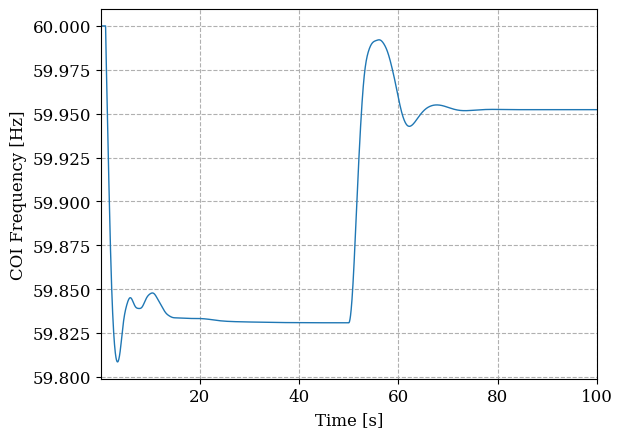

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Time [s]', ylabel='COI Frequency [Hz]'>)

In [23]:
sa.TDS.plt.plot(sa.COI.omega,
                ytimes=sa.config.freq,
                latex=False,
                grid=True,
                legend=False,
                ylabel='COI Frequency [Hz]')